In [1]:
%matplotlib inline

##Question 5:
Assuming previous tutorial has been done. We will start with our base CNN from the "What is torch.nn" tutorial.

### Loading MNIST Dataset

(50000, 784)


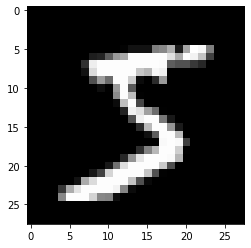

In [2]:
# Loading Dataset libraries
from pathlib import Path
import requests
import pickle
import gzip
# Computional and Graphical libraries
from matplotlib import pyplot
import numpy as np
import torch
# Debugger Library
from IPython.core.debugger import set_trace

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")
  
pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)

### Is GPU availble?

In [3]:
print(torch.cuda.is_available())
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

True


### Classes and Functions

In [4]:
# Training and Validation Datasets/DataLoaders Libraries
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
# Optim and NN libraries
from torch import optim
from torch import nn
import torch.nn.functional as F

def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

loss_func = F.cross_entropy

def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        val_acc = sum(accuracy(model(xb), yb) for xb, yb in valid_dl)    #valid_loss / len(valid_dl)

        val_acc = val_acc.cpu().detach().numpy() 
        print(epoch, val_loss, val_acc / len(valid_dl))

class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

def preprocess(x, y):
    return x.view(-1, 1, 28, 28).to(dev), y.to(dev)

class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

# Accuracy check from Validation Test.
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

### Initial Variables

In [5]:
bs = 64  # batch size
lr = 0.1  # learning rate
epochs = 2  # how many epochs to train for
a = np.zeros((20, 10), dtype=(float,5))

### Training and Validation Datasets/DataLoaders 


In [6]:
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

### Model and Optim (Use to do Foward Step)

In [7]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)
model.to(dev)
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

### Training of Model. Outputs Validation Loss.


In [8]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.339774385368824 0.8920094936708861
1 0.21009030851125718 0.9386867088607594


### Testing different learning rate and momentum values.


In [10]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl, mat, lr, momentum):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )

        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        val_acc = sum(accuracy(model(xb), yb) for xb, yb in valid_dl)    #valid_loss / len(valid_dl)
        val_acc = val_acc.cpu().detach().numpy() / len(valid_dl)
        mat_data = (epoch, lr, momentum, val_loss, val_acc)
        mat[int(((lr*20)-2)+epoch)][int(momentum*10)] = mat_data
        print(epoch, val_loss, val_acc)
    return mat
################################################################################
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)
model.to(dev)
for x in range(10):           # Varying for LR from 0.1 to 1.0  
  lr = (x+1)/10
  for y in range(10):         # Varying for Momentum 0.0 to 0.9
    momentum = y/10
    opt = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    print(lr, momentum)
    a = fit(epochs, model, loss_func, opt, train_dl, valid_dl, a, lr, momentum)


0.1 0.0
0 1.4863000289916992 0.45905854430379744
1 1.1271489278793334 0.6269778481012658
0.1 0.1
0 0.6791762075424195 0.7776898734177216
1 0.6144604323863984 0.7991495253164557
0.1 0.2
0 0.3710880497455597 0.8862737341772152
1 0.37908401839733125 0.8816257911392406
0.1 0.3
0 0.2817768128156662 0.9165348101265823
1 0.2684560010433197 0.9212816455696202
0.1 0.4
0 0.25333035026788714 0.9282041139240507
1 0.2586450876951218 0.9212816455696202
0.1 0.5
0 0.4873069658279419 0.8554193037974683
1 0.28710642221570015 0.912381329113924
0.1 0.6
0 0.24276638667583467 0.9288963607594937
1 0.18893379352390766 0.9445213607594937
0.1 0.7
0 0.22176867967247962 0.9373022151898734
1 0.19824675492346286 0.9425435126582279
0.1 0.8
0 0.18635324544012546 0.9465981012658228
1 0.1841644081056118 0.9479825949367089
0.1 0.9
0 0.16314728631675243 0.9553006329113924
1 0.18670903607010841 0.9434335443037974
0.2 0.0
0 0.18890684643387795 0.9449169303797469
1 0.13567996456772088 0.9623219936708861
0.2 0.1
0 0.13560908

### Graphical Illustration of Accuracy for Varying Values of Learning Rate and Momentum

In [11]:
def Largest_Moment(mat, index):
  best_Momentum_index = 0;
  for x in range(10):
    if(mat[index][x][4] > mat[index][best_Momentum_index][4]):
      best_Momentum_index = x
  return best_Momentum_index

mat_lr = np.zeros(20)
mat_moment = np.zeros(20)
mat_acc = np.zeros(20)

for i in range(20):
  mat_lr[i] = a[i][0][1]
  # Momentum index with greatest Accuracy of a given LR.
  large = Largest_Moment(a, i)
  mat_moment[i] = a[i][large][2]
  mat_acc[i] = a[i][large][4]

The arrays of LR, Momentum, and Accuracy should be counted in groups of 2. First Value is epoch 1, second value is epoch 2. Then LR/Momentum will increment. For example, below we see that the 8th value in accuracy array is the largest. This corresponds to a learning rate of 0.5 and momentum 0.4 and epoch 1. Loss of valiation sets are also shown as 0.9500714. 

In [15]:
print(mat_acc)
print(mat_moment[10])
print(a[10][3])

[0.95530063 0.94798259 0.96538766 0.96578323 0.97102453 0.96924446
 0.97053006 0.9726068  0.97092563 0.97072785 0.97329905 0.97211234
 0.96835443 0.96805775 0.96716772 0.96657437 0.95500396 0.95549842
 0.95253165 0.95213608]
0.3
[0.         0.6        0.3        0.10774975 0.97329905]


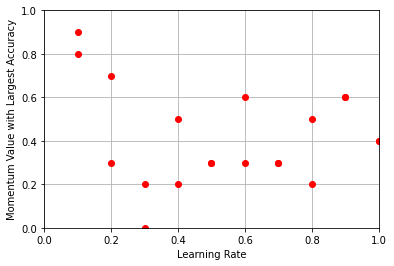

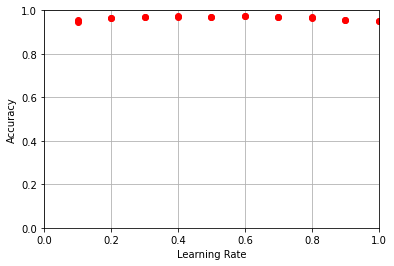

In [13]:
fig, ax = pyplot.subplots()
ax.plot(mat_lr, mat_moment, 'ro')
ax.axis([0, 1, 0, 1])
ax.set(xlabel='Learning Rate', ylabel='Momentum Value with Largest Accuracy')
ax.grid()
pyplot.show()

fig, ax = pyplot.subplots()
ax.plot(mat_lr, mat_acc, 'ro')
ax.axis([0, 1, 0, 1])
ax.set(xlabel='Learning Rate', ylabel='Accuracy')
ax.grid()
pyplot.show()

From the plot above. We got our best accuracy, 0.97329905 , with a learning rate of 0.6 and a momentum of 0.3. In the graphs above, every LR has two dots since there is 2 epochs.